In [1]:
import numpy as np
import math
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import glob
import copy
import pandas as pd
import os
from scipy.optimize import curve_fit
from scipy import optimize
from dateutil.parser import parse
from scipy.stats import poisson, norm
import datetime
from scipy.signal import find_peaks
from matplotlib import colors

In [2]:
# plt.rcParams.update({
#     "image.origin": "lower",
#     "image.aspect": 1,
#     "text.usetex": True,
#     "grid.alpha": .5,
#     }) 

## Analysis Images -- CONNIE style
by Carla for Labo 6 y 7

In [2]:
# Abrimos las imagenes de las 2 skipper-ccds instaladas en CONNIE usando fits.open de astropy.os
img1=fits.open('TRAPS/29JUN2023/proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE300_img5.fits')
img2=fits.open('TRAPS/29JUN2023/proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img87.fits')

# Cada imagen tiene 4 amplificadores que leemos al mismo tiempo.  En el caso de CONNIE mandamos señal
# a solo 2 amplificadores. ¿Cuáles?  Mirando los datos podemos saber cuales...
# Usamos info para saber que tienen los datos:
img1.info()
img2.info()

Filename: TRAPS/29JUN2023/proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE300_img5.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     159   (336, 829)   float32   
  1                1 ImageHDU       158   (336, 829)   float32   
  2                1 ImageHDU       158   (336, 829)   float32   
  3                1 ImageHDU       158   (336, 829)   float32   
Filename: TRAPS/29JUN2023/proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img87.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     159   (336, 829)   float32   
  1                1 ImageHDU       158   (336, 829)   float32   
  2                1 ImageHDU       158   (336, 829)   float32   
  3                1 ImageHDU       158   (336, 829)   float32   


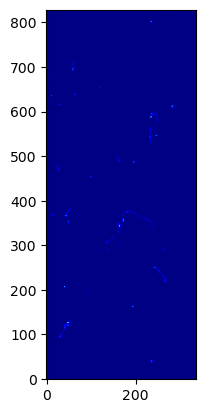

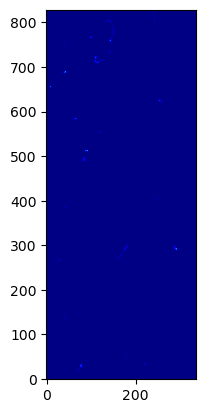

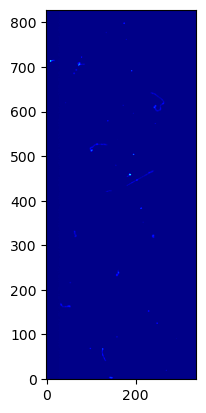

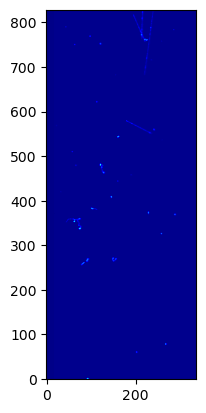

In [13]:
for frame in img1:
    plt.imshow(frame.data, cmap="jet", origin="lower")
    plt.show()

Podemos ver que tenemos en cada skipper-ccd los 4 canales uno por cada amplificacor y que las dimensiones son de 420 columnas y 1022 filas

Hay que tener en cuenta que las últimas 70 columnas son las que se corresponden al overscan (OS) que es la parte que leemos a mas en el serial register SR para poder tener una medida de pixeles sin carga. También hay que tener en cuenta que las primeras 8 columnas corresponden al prescan.

In [4]:
# definimos las regiones (máscaras) activa y de overscan
active_mask = np.s_[:, 9:-71]
overscan_mask = np.s_[:, -65:-5] # eliminamos las primeras columnas y ultimas columnas


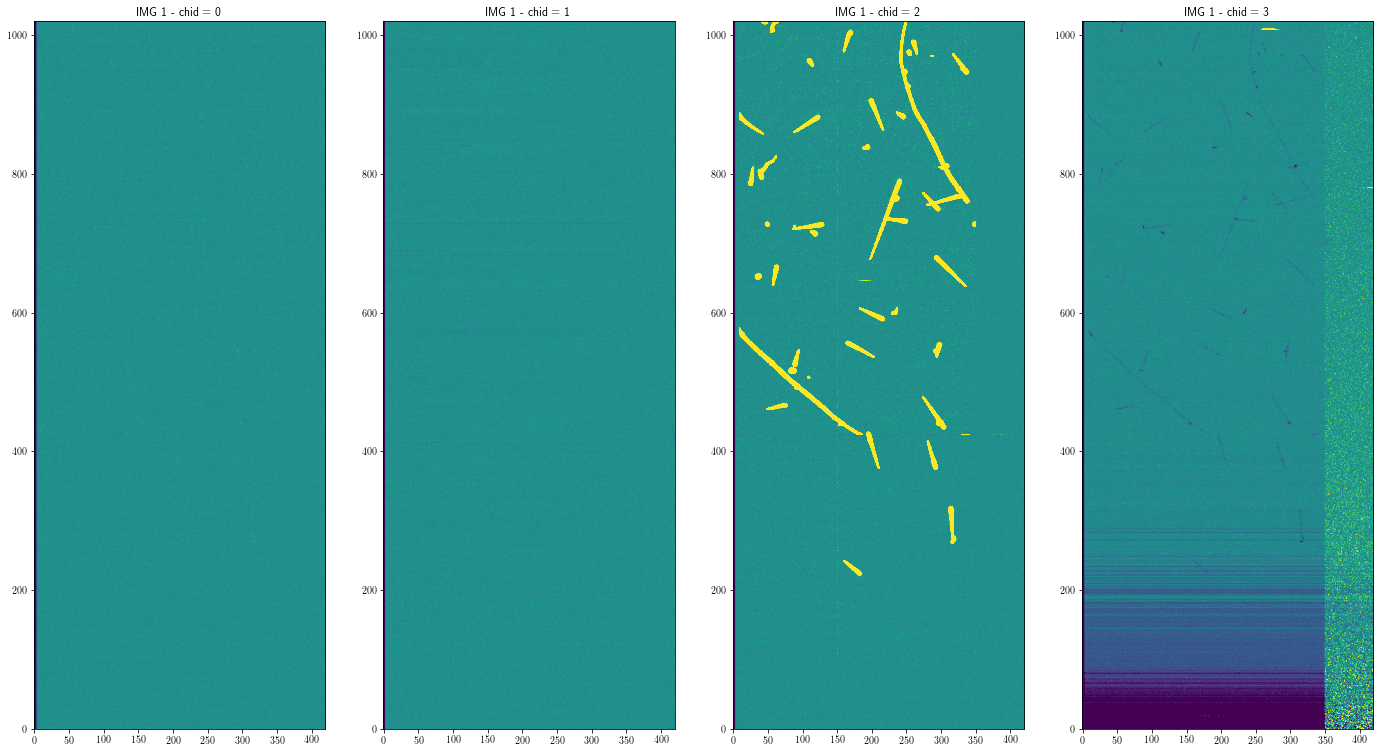

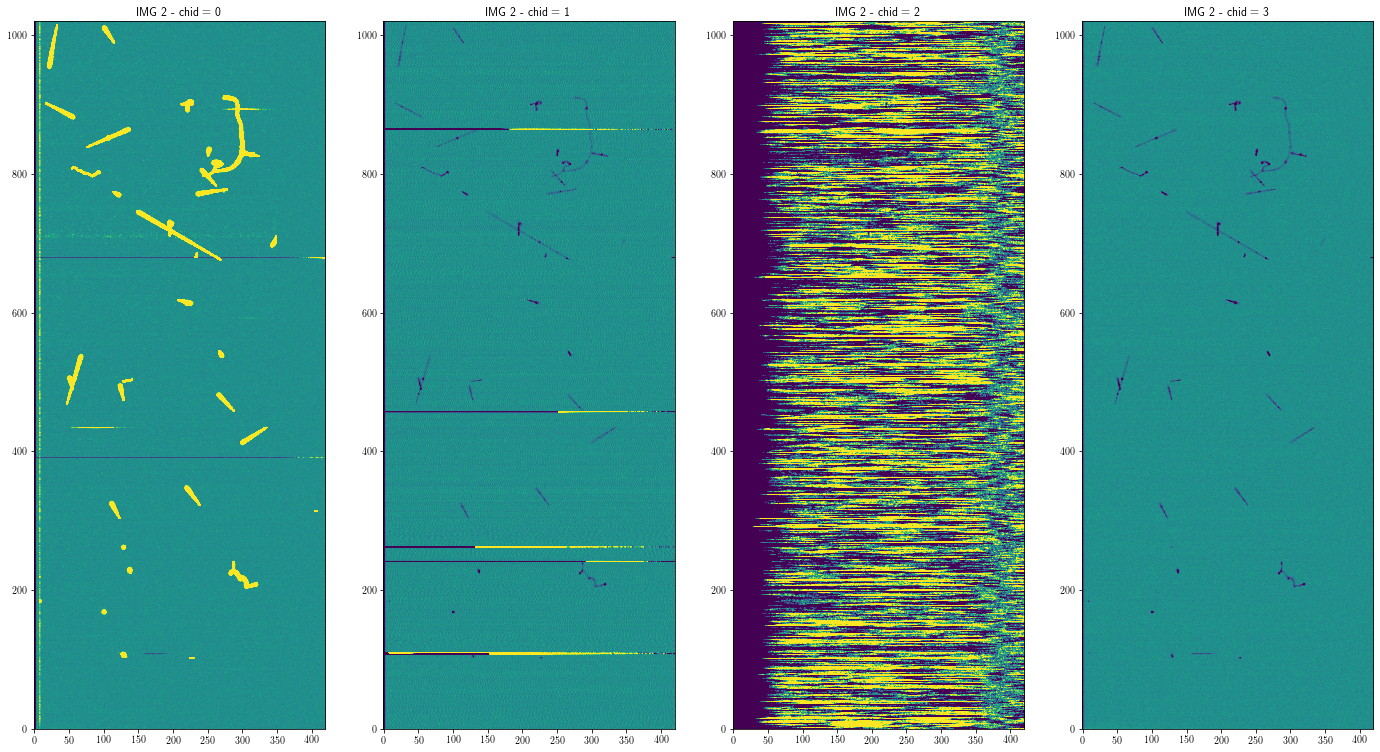

In [5]:
# Graficamos las imagenes completas substrayendo la mediana (global) del OS.  Esto lo hacemos para poner el valor 
# de pixel vacio en el cero y así queda mas fácil y podemos ajustar bien la escala.
# Para la img1
plt.figure(figsize=(24,24))
for i in range(4):
    plt.subplot(1,4,i+1)    
    plt.imshow(img1[i].data[:,:]-np.median(img1[i].data[overscan_mask],axis=1, keepdims=True ), vmin=-1000, vmax=1000)
    plt.title('IMG 1 - chid = {:d}'.format(i))

# Lo mismo para la img2    
plt.figure(figsize=(24,24))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(img2[i].data[:,:]-np.median(img2[i].data[overscan_mask],axis=1, keepdims=True ), vmin=-1000, vmax=1000)
    plt.title('IMG 2 - chid = {:d}'.format(i))
    


Mirando las imagenes decir que canales (amplificadores) están funcionando en cada img y por qué.

Adquisición de imagenes:
Estas imagenes son adquiridas sin exposición y después de haber hecho una limpieza de las mismas.  Es decir que el primer pixel tiene tiempo de exposición 0 y el último, máximo (ya que para que este pixel pueda ser leido se tuvieron que leer antes todos los pixeles).

In [6]:
# Vamos a estimar el tiempo de exposición/lectura, para eso vamos a sacar la información del header
print(img1[0].header["DATEEND"],img1[0].header["DATESTART"])
start = parse(img1[0].header["DATESTART"]+"Z").timestamp()
end = parse(img1[0].header["DATEEND"]+"Z").timestamp()
deltatime = datetime.timedelta(seconds=end-start)
readout_time = deltatime.total_seconds()
print(readout_time, "s")
print(round(readout_time/3600,2), "h")
print(round(readout_time/86400,3), "days")

2022-06-30T20:52:48 2022-06-30T18:54:10
7118.0 s
1.98 h
0.082 days


## Definimos las funciones que vamos a usar en el análisis

In [7]:
# Gaussiana de 1D centrada em m1 de sigma s1 y amplitud a1
def gaussian1(x,m1,s1,a1):
    return a1*np.exp(-1/2*((x-m1)/s1)**2)

# 2 Gaussianas de 1D con la segunda desplazada en g (ganancia) con respecto a la primera centrada en m1. Ambas tienen
# el mismos sigma s y amplitud de a1 para la primera y a2 para la segunda
def gaussian2(x,m1,s,a1,g,a2):
    return a1*np.exp(-1/2*((x-m1)/s)**2)+a2*np.exp(-1/2*((x-m1-g)/s)**2)


## Preparamos las imagenes con datos para ser analizadas

In [8]:
# selección de canales el 0 de la img1 y el 2 de la img2
data0 = img2[0].data[:,:]
data2 = img1[2].data[:,:]

ysize =1022

# subtract active medians
data0 -= np.median( data0[overscan_mask], axis=1, keepdims=True )
data2 -= np.median( data2[overscan_mask], axis=1, keepdims=True )

# remove median of first 100 rows
verticaloverscan_mask = np.s_[:10,:]
data0 -= np.median( data0[verticaloverscan_mask], axis=0, keepdims=True )
data2 -= np.median( data2[verticaloverscan_mask], axis=0, keepdims=True )


Text(0.5, 1.0, 'img1  - chid = 2')

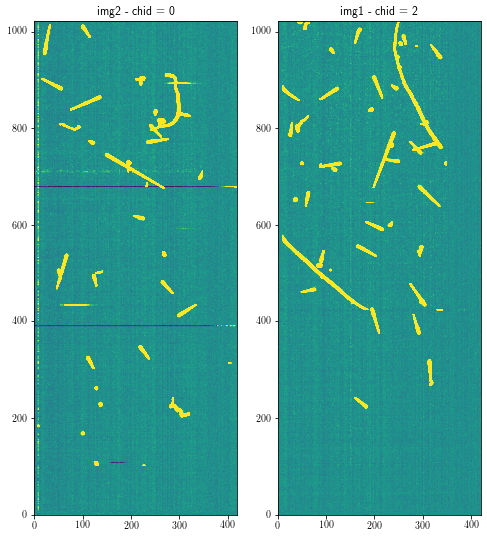

In [9]:
# Graficar las imagenes seleccionadas

plt.figure(figsize=(8,10))

plt.subplot(1,2,1)
plt.imshow(data0, vmin=-500, vmax=500)
plt.title('img2  - chid = 0')              # ACDS-10
plt.subplot(1,2,2)
plt.imshow(data2, vmin=-500, vmax=500)
plt.title('img1  - chid = 2')              # ACDS-11


Ahora vamos a ver la distribución de carga, para un número bajo de carga (pocos electrones) en la región de la parte activa y en la región del overscan. Observar las distribuciones. ¿Qué podemos decir?

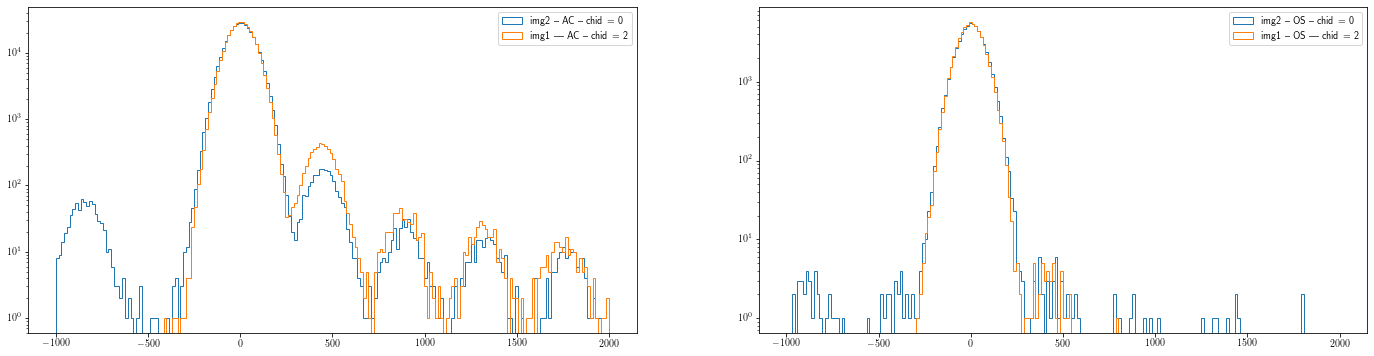

In [10]:
plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.yscale('log')
plt.hist(data0[active_mask].flatten(),histtype='step',bins=200,range=[-1e3,2e3],label='img2 – AC – chid = 0')
plt.hist(data2[active_mask].flatten(),histtype='step',bins=200,range=[-1e3,2e3],label='img1 — AC –  chid = 2')
plt.legend()
plt.subplot(1,2,2)
plt.yscale('log')
plt.hist(data0[overscan_mask].flatten(),histtype='step',bins=200,range=[-1e3,2e3],label='img2 – OS – chid = 0')
plt.hist(data2[overscan_mask].flatten(),histtype='step',bins=200,range=[-1e3,2e3],label='img1 – OS — chid = 2')
plt.legend()

## Calibrando las skipper-CCDs a partir de ajustar una doble gaussiana y calculando g. 

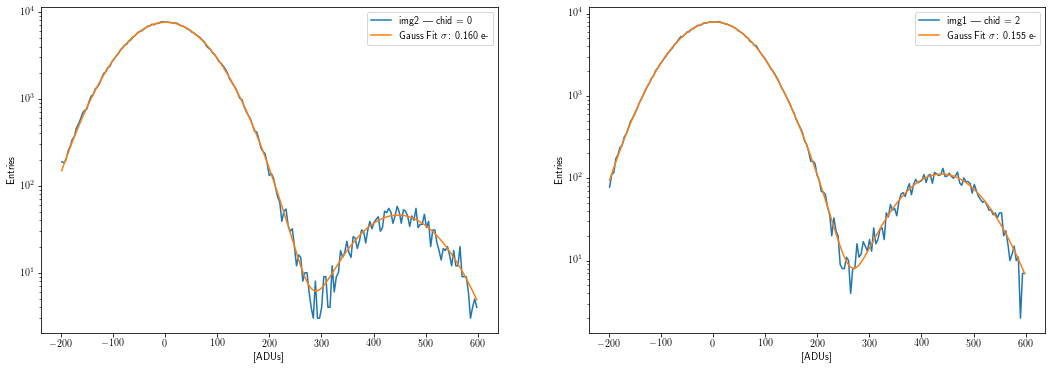

In [11]:
# usamos la parte activa y transformamos el array de 2dim en uno de 1dim usando flatten

plt.figure(figsize=(18,6))

# grafico el histograma de carga
plt.subplot(1,2,1)
y,xb=np.histogram(data0[active_mask].flatten(),bins=np.linspace(-200,600,200))
x=(xb[1:]+xb[:-1])/2
# hago el fit
popt,pcov=curve_fit(gaussian2,x,y,p0=[-10,70,10000,450,1000])
plt.plot(x,y,label='img2 — chid = 0')
gain0=popt[3]
#grafico la función ajustada
plt.plot(x,gaussian2(x,*popt),label="Gauss Fit $\sigma$: {:.3f} e-".format((popt[1])/gain0))
plt.legend()
plt.xlabel("[ADUs]")
plt.yscale("log")
plt.ylabel("Entries")
plt.yscale('log')

plt.subplot(1,2,2)
y,xb=np.histogram(data2[active_mask].flatten(),bins=np.linspace(-200,600,200))
x=(xb[1:]+xb[:-1])/2
popt,pcov=curve_fit(gaussian2,x,y,p0=[-10,60,10000,450,1000])
plt.plot(x,y,label='img1 — chid = 2')
gain2=popt[3]
plt.plot(x,gaussian2(x,*popt),label="Gauss Fit $\sigma$: {:.3f} e-".format((popt[1])/gain2))
plt.legend()
plt.xlabel("[ADUs]")
plt.yscale("log")
plt.ylabel("Entries")
plt.yscale('log')
          


In [12]:
# --------------------------------------

print('Ganancia img2 — chid = 0 in ADUs/e-: {:.3f}'.format((gain0)))
print('Ganancia img1 — chid = 2 in ADUs/e-: {:.3f}'.format((gain2)))

# Calibro los datos, a partir de aqui vamos a tener las cargas en e- y no mas en ADUs
data0/=gain0
data2/=gain2


Ganancia img2 — chid = 0 in ADUs/e-: 445.379
Ganancia img1 — chid = 2 in ADUs/e-: 435.903


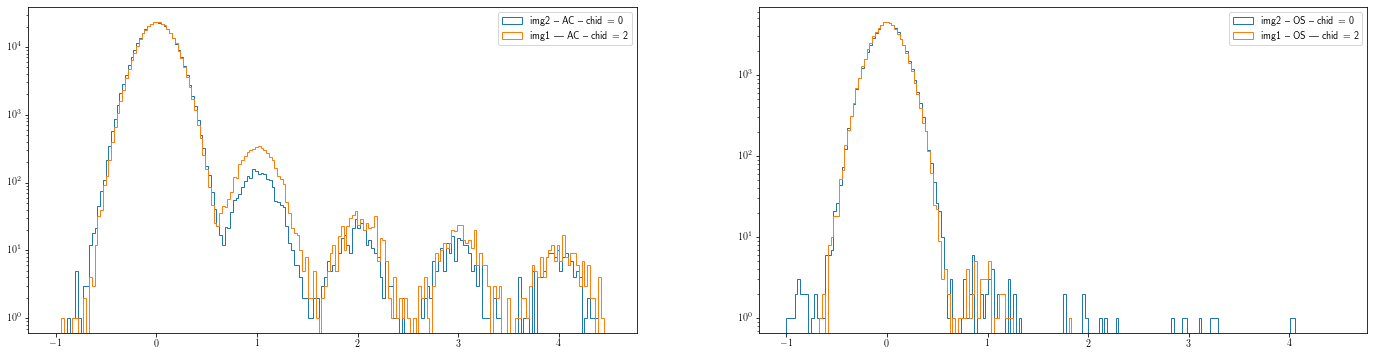

In [13]:
# Vamos a graficar las distribuciones de carga para los primeros electrones de nuevo
# ver como cambio el range (rango)

plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.yscale('log')
plt.hist(data0[active_mask].flatten(),histtype='step',bins=200,range=[-1,4.5],label='img2 – AC – chid = 0')
plt.hist(data2[active_mask].flatten(),histtype='step',bins=200,range=[-1,4.5],label='img1 — AC –  chid = 2')
plt.legend()
plt.subplot(1,2,2)
plt.yscale('log')
plt.hist(data0[overscan_mask].flatten(),histtype='step',bins=200,range=[-1,4.5],label='img2 – OS – chid = 0')
plt.hist(data2[overscan_mask].flatten(),histtype='step',bins=200,range=[-1,4.5],label='img1 – OS — chid = 2')
plt.legend()

## Determinación del ruido de lectura usando solo la región del OS en los datos calibrados

Ruido de lectura img2 — chid = 0 in ADUs/e-: 0.151 ± 0.001
Ruido de lectura img1 — chid = 2 in ADUs/e-: 0.151 ± 0.001


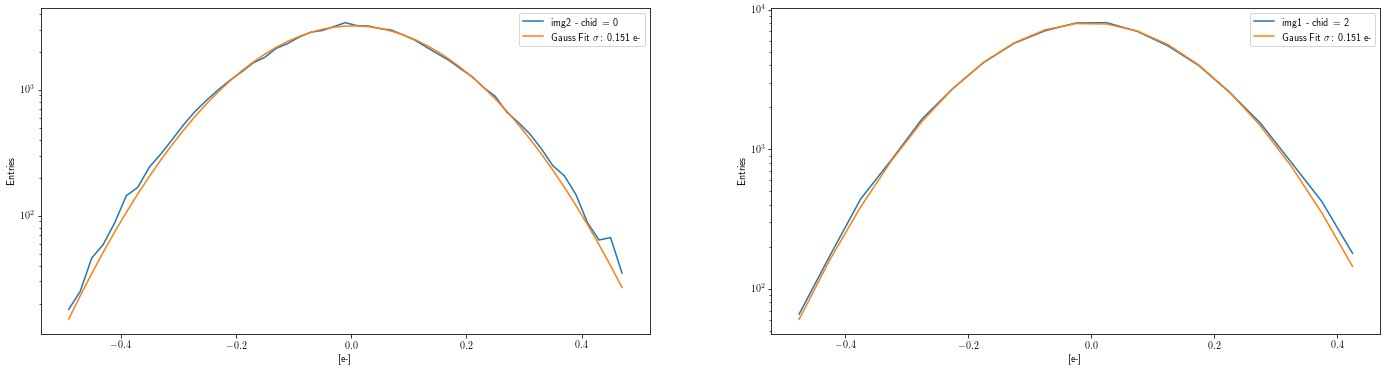

In [14]:
plt.figure(figsize=(24,6))
plt.subplot(1,2,1)

# noise in the OS
y,xb = np.histogram(data0[overscan_mask].flatten(), bins = np.arange(-0.5, 0.5, 0.02) )
x=(xb[1:]+xb[:-1])/2
plt.plot(x,y,label='img2 - chid = 0' )

try:
    popt, pcov = curve_fit( gaussian1, x, y, p0=[ 0, 0.3, 1e5] )
        # get error from pcov
except RuntimeError:
    print(f"Error - gain fit failed, {path}")
    print("This file will not be saved")
    # returns at exception without writing
    #return
#     print( popt )
perr = np.sqrt(np.diag(pcov))
sigmaOS0 = popt[1]
sigmaOS0_err = perr[1]
plt.plot(x,gaussian1(x,*popt),label="Gauss Fit $\sigma$: {:.3f} e-".format(sigmaOS0))
plt.legend()
plt.xlabel("[e-]")
plt.yscale("log")
plt.ylabel("Entries")


plt.subplot(1,2,2)
# noise in the OS
y,xb = np.histogram(data2[overscan_mask].flatten(), bins = np.arange(-0.5, 0.5, 0.05) )
x=(xb[1:]+xb[:-1])/2
plt.plot(x,y,label='img1 - chid = 2' )
try:
    popt, pcov = curve_fit( gaussian1, x, y, p0=[ 0, 0.2, 1e5] )
        # get error from pcov
except RuntimeError:
    print(f"Error - gain fit failed, {path}")
    print("This file will not be saved")
    # returns at exception without writing
    #return
#     print( popt )
perr = np.sqrt(np.diag(pcov))
sigmaOS2 = popt[1]
sigmaOS2_err = perr[1]
plt.plot(x,gaussian1(x,*popt),label="Gauss Fit $\sigma$: {:.3f} e-".format(sigmaOS2))
plt.legend()
plt.xlabel("[e-]")
plt.yscale("log")
plt.ylabel("Entries")

# --------------------------------------

print('Ruido de lectura img2 — chid = 0 in ADUs/e-: {:.3f} ± {:.3f}'.format(sigmaOS0,sigmaOS0_err))
print('Ruido de lectura img1 — chid = 2 in ADUs/e-: {:.3f} ± {:.3f}'.format(sigmaOS2,sigmaOS2_err))

## Calculo de la tasa de electron único (SEE = single electron event)

Para calcular el SEE necesitamos enmascarar todos los eventos de alta energia y sus halos (primeros 10 vecinos, para evitar contaminar el número de eventos de single electron con secundarios provenientes de la pasaje de los eventos de alta energia por el sistema.

Text(0.5, 1.0, 'img1 - chid = 2 - mask')

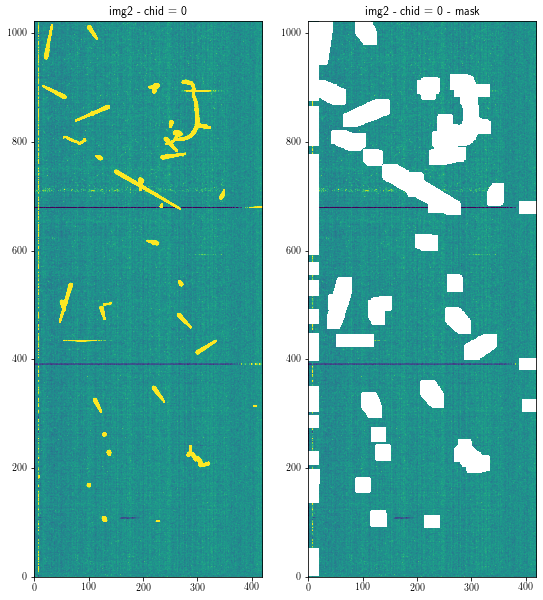

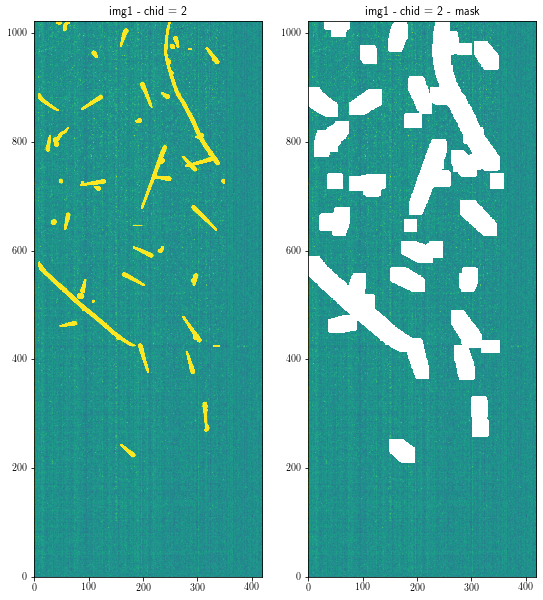

In [15]:

itera=10

mask = ndimage.binary_dilation(data0>5,iterations=itera,structure=[[1,1,1],[1,1,1],[1,1,1]])  
data0mask = data0 - 1000000*mask.astype(data0.dtype)
data0mask = np.ma.masked_less(data0mask, -50000)

mask = ndimage.binary_dilation(data2>5,iterations=itera,structure=[[1,1,1],[1,1,1],[1,1,1]])  
data2mask = data2 - 1000000*mask.astype(data2.dtype)
data2mask = np.ma.masked_less(data2mask, -50000)

plt.figure(figsize=(9,18))
plt.subplot(1,2,1)
plt.imshow(data0, vmin=-1, vmax=1, origin='lower')
plt.title('img2 - chid = 0')
plt.subplot(1,2,2)
plt.imshow(data0mask, vmin=-1, vmax=1, origin='lower')
plt.title('img2 - chid = 0 - mask')

plt.figure(figsize=(9,18))
plt.subplot(1,2,1)
plt.imshow(data2, vmin=-1, vmax=1, origin='lower')
plt.title('img1 - chid = 2')
plt.subplot(1,2,2)
plt.imshow(data2mask, vmin=-1, vmax=1, origin='lower')
plt.title('img1 - chid = 2 - mask')

Como podemos ver, estas máscaras no son suficientes, hay otros "efectos" que deberiamos eliminar par auna correcta determinación del SEE, pero esto lo podemos ir mejorando mas adelante.  Vamos a calcular la tasa, a partir de la convolución.

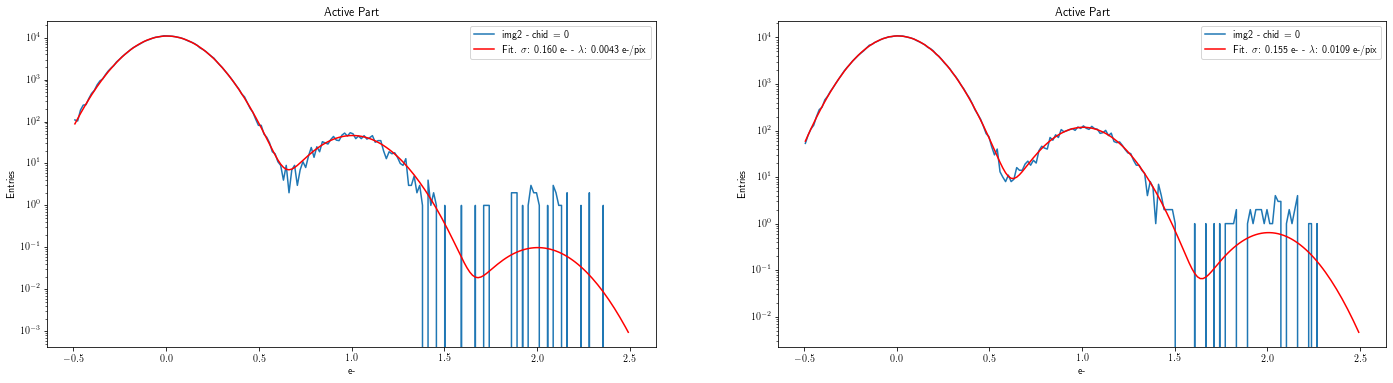

In [16]:
# Función convolución entre la distribución Gaussina y Poisson para poder estimar la tasa de eventos de un electrón en 
# la región activa. Ver tesis de Miguel para referencia.
def myfunc(x, mu, sigma, A, lamb, Nmax=10):
    y = 0.
    for i in range(0, Nmax+1):
        y += (lamb**i)/float(math.factorial(i)) * \
            np.exp(-0.5*((x-i-mu-lamb)/float(sigma))**2)
    return A*np.exp(-lamb)*y/(np.sqrt(2*np.pi*sigma**2))


plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
y, xb = np.histogram(data0mask[active_mask].flatten(),range=[-0.5,2.5],bins=200)
x = (xb[1:]+xb[:-1])/2
popt, pcov = curve_fit(myfunc, x, y, p0=[-0.4, 0.2, 1000, 0.1])
plt.plot(x, y,label="img2 - chid = 0")
plt.plot(x, myfunc(x, *popt), label="Fit. $\sigma$: {:.3f} e- -  $\lambda$: {:.4f} e-/pix ".format(abs(popt[1]),popt[3]),color='red')
plt.xlabel("e-")
plt.ylabel("Entries")
plt.yscale("log")
plt.title(" Active Part")
plt.legend()
noise0 = popt[1]
lambda0 = popt[3]

plt.subplot(1,2,2)
y, xb = np.histogram(data2mask[active_mask].flatten(),range=[-0.5,2.5],bins=200)
x = (xb[1:]+xb[:-1])/2
popt, pcov = curve_fit(myfunc, x, y, p0=[-0.4, 0.2, 1000, 0.1])
plt.plot(x, y,label="img2 - chid = 0")
plt.plot(x, myfunc(x, *popt), label="Fit. $\sigma$: {:.3f} e- -  $\lambda$: {:.4f} e-/pix ".format(abs(popt[1]),popt[3]),color='red')
plt.xlabel("e-")
plt.ylabel("Entries")
plt.yscale("log")
plt.title(" Active Part")
plt.legend()
noise2 = popt[1]
lambda2 = popt[3]


# lambda que es la tasa está en unidades de e-/pix para esa imagen


In [17]:
!jupyter nbconvert --to html anaImagen.ipynb


[NbConvertApp] Converting notebook anaImagen.ipynb to html
[NbConvertApp] Writing 5394009 bytes to anaImagen.html
